In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
#os.nice(1) 

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from pathlib import Path
def ensure_dir(path):
    path.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/')

In [6]:
import pandas  as pd
#from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed

In [7]:
from pathlib import Path
def ensure_dir(path):
    path.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/')

In [8]:
spikerate_variance_dfs = list((DATA_DIR / 'spikerate_variance').glob('*.csv'))
spikerate_variance_dfs

[PosixPath('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/spikerate_variance/B1595.csv'),
 PosixPath('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/spikerate_variance/B1593.csv'),
 PosixPath('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/spikerate_variance/B1426.csv'),
 PosixPath('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/spikerate_variance/B1170.csv'),
 PosixPath('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/spikerate_variance/B1244.csv'),
 PosixPath('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/spikerate_variance/B1248.csv'),
 PosixPath('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/spikerate_variance/B1432.csv'),
 PosixPath('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/spikerate_variance/B1597.csv'),
 PosixPath('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data/spikerate_variance/B1188.csv')]

In [9]:
all_unit_spikerates = pd.concat([pd.read_csv(i) for i in spikerate_variance_dfs])

In [10]:
len(all_unit_spikerates)

417841

In [11]:
all_unit_spikerates[:3]

,Unnamed: 0,cue_valid,stim_id,mean,std,count,unit
0,0,invalid,CL0_0,1.428571,1.342460,14,B1595_387
1,1,invalid,CL0_1,1.076923,1.187542,13,B1595_387
2,2,invalid,CL0_2,1.565217,1.926516,23,B1595_387


In [13]:
# split into stimuli and cue
cues = [i.split('_')[0] for i in all_unit_spikerates.stim_id.values]
stims = [i.split('_')[1] for i in all_unit_spikerates.stim_id.values]
all_unit_spikerates['cues'] = cues
all_unit_spikerates['stims'] = stims

In [14]:
all_unit_spikerates[:3]

,Unnamed: 0,cue_valid,stim_id,mean,std,count,unit,cues,stims
0,0,invalid,CL0_0,1.428571,1.342460,14,B1595_387,CL0,0
1,1,invalid,CL0_1,1.076923,1.187542,13,B1595_387,CL0,1
2,2,invalid,CL0_2,1.565217,1.926516,23,B1595_387,CL0,2


### stats

In [29]:
df = all_unit_spikerates.reset_index()[['stims', 'cue_valid', 'cues', 'unit', 'std']]
df = df[pd.isnull(df['std']) == False]
df['cues'] = df['cues'].astype('category')
df['unit'] = df['unit'].astype('category')
df['stims'] = df['stims'].astype('category')
df['unit_stimulus_interaction'] = df['unit'].astype(str) + ':' + df['stims'].astype(str)
df['unit_stimulus_interaction'] = df['unit_stimulus_interaction'].astype('category')
df = df[df.cue_valid.isin(['valid', 'invalid'])]

In [30]:
df[:3]

,stims,cue_valid,cues,unit,std,unit_stimulus_interaction
0,0,invalid,CL0,B1595_387,1.342460,B1595_387:0
1,1,invalid,CL0,B1595_387,1.187542,B1595_387:1
2,2,invalid,CL0,B1595_387,1.926516,B1595_387:2


In [31]:
len(df.unit_stimulus_interaction.unique())

85352

In [57]:
# Mixed Linear Model
model = smf.mixedlm("std ~ cue_valid", df, groups=df["unit_stimulus_interaction"])

In [58]:
result = model.fit()

In [59]:
# Summary of the model
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM  Dependent Variable:  std         
No. Observations:   262260   Method:              REML        
No. Groups:         85352    Scale:               6.6054      
Min. group size:    1        Log-Likelihood:      -699260.2369
Max. group size:    4        Converged:           Yes         
Mean group size:    3.1                                       
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           4.684    0.014 341.939 0.000  4.657  4.711
cue_valid[T.valid] -0.515    0.011 -47.827 0.000 -0.536 -0.494
Group Var          12.324    0.033                            
==============================================================

"""

### plotting

In [42]:
all_unit_spikerates_pivot = all_unit_spikerates.pivot_table(index=['stims', 'unit'], columns='cue_valid', values=['mean', 'std', 'count'], aggfunc='first')


In [43]:
all_unit_spikerates_pivot[:3]

count                   mean                       std  \
cue_valid        invalid uncued valid   invalid    uncued valid   invalid   
stims unit                                                                  
0     B1170_1002    21.0   12.0  10.0  2.476190  2.250000  4.20  3.880967   
      B1170_1027    84.0   22.0  20.0  1.095238  1.636364  2.05  1.572497   
      B1170_1037    21.0   12.0  10.0  7.142857  9.666667  7.80  4.850626   

                                      
cue_valid           uncued     valid  
stims unit                            
0     B1170_1002  1.912875  3.521363  
      B1170_1027  2.279212  3.186732  
      B1170_1037  5.820549  5.432413

In [45]:
all_unit_spikerates_pivot["mean_diff"] = all_unit_spikerates_pivot['mean']['valid'] - all_unit_spikerates_pivot['mean']['invalid']
all_unit_spikerates_pivot["std_diff"] = all_unit_spikerates_pivot['std']['valid'] - all_unit_spikerates_pivot['std']['invalid']

In [46]:
np.nanmedian(all_unit_spikerates_pivot["std_diff"])

-0.26227266202782773

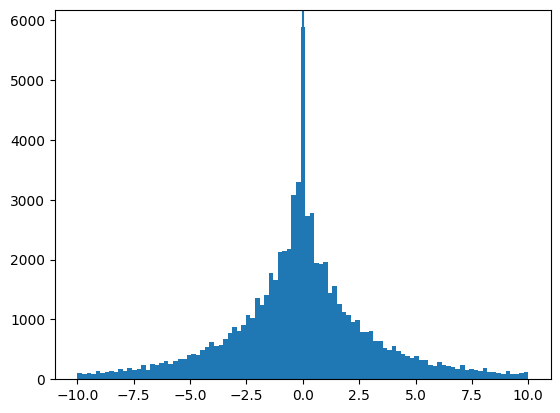

In [53]:
fig, ax = plt.subplots()
ax.hist(all_unit_spikerates_pivot.mean_diff.values, bins = np.linspace(-10, 10, 100));
ax.axvline(0)